<a href="https://colab.research.google.com/github/rishi15-t/PP-MM/blob/master/BaseModelGMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
dataset = pd.read_pickle('/content/drive/My Drive/dataset/w2v_vgg_embeddings.pkl')

In [0]:
'''
import pandas as pd
import h5py
import numpy as np

hf = h5py.File('C:/Users/shram/Desktop/multimodal_imdb.hdf5', 'r')
n1 = pd.Series(hf.get('vgg_features'))
n2 = pd.Series(hf.get('features'))
n3 = pd.Series(hf.get('genres'))
n4 = pd.Series(hf.get('imdb_ids'))

dataset = pd.DataFrame(dict(n1 = n1, n2 = n2, n3 = n3, n4 = n4)).reset_index()
dataset = dataset.rename(columns={"n1": "vgg16_embeddings", "n2": "w2v_embeddings", "n3" : "genres", "n4" : "fileID"})
del dataset['index']
dataset['vgg16_embeddings'] = dataset['vgg16_embeddings'].apply(lambda x : list(map(float, x)))
dataset['w2v_embeddings'] = dataset['w2v_embeddings'].apply(lambda x : list(map(float, x)))
dataset['genres'] = dataset['genres'].apply(lambda x : list(map(int, x)))
dataset

#dataset.to_hdf('w2v_embeddings.h5', key='embeddings', mode='w')
'''

'\nimport pandas as pd\nimport h5py\nimport numpy as np\n\nhf = h5py.File(\'C:/Users/shram/Desktop/multimodal_imdb.hdf5\', \'r\')\nn1 = pd.Series(hf.get(\'vgg_features\'))\nn2 = pd.Series(hf.get(\'features\'))\nn3 = pd.Series(hf.get(\'genres\'))\nn4 = pd.Series(hf.get(\'imdb_ids\'))\n\ndataset = pd.DataFrame(dict(n1 = n1, n2 = n2, n3 = n3, n4 = n4)).reset_index()\ndataset = dataset.rename(columns={"n1": "vgg16_embeddings", "n2": "w2v_embeddings", "n3" : "genres", "n4" : "fileID"})\ndel dataset[\'index\']\ndataset[\'vgg16_embeddings\'] = dataset[\'vgg16_embeddings\'].apply(lambda x : list(map(float, x)))\ndataset[\'w2v_embeddings\'] = dataset[\'w2v_embeddings\'].apply(lambda x : list(map(float, x)))\ndataset[\'genres\'] = dataset[\'genres\'].apply(lambda x : list(map(int, x)))\ndataset\n\n#dataset.to_hdf(\'w2v_embeddings.h5\', key=\'embeddings\', mode=\'w\')\n'

In [0]:
import torch
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


def Train_Test_Val_Split(data , test_data_fraction = 0.3, val_data_fraction = 0.1) :
    
  
    data_genres_one_hot_encoding = pd.DataFrame.from_items(zip(data['genres'].index, data['genres'].values)).T
    Label_names = np.array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'])
    data_genres_one_hot_encoding.columns = Label_names
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, data_genres_one_hot_encoding, test_size = test_data_fraction)

    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    
    Labels_train = torch.tensor(Labels_train.values)
    Labels_test = torch.tensor(Labels_test.values)
    Labels_val = torch.tensor(Labels_val.values)
    
    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val, Label_names)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor, Label_names = Train_Test_Val_Split(dataset)

Data_train_tensor_text = torch.tensor(Data_train['w2v_embeddings'])
Data_test_tensor_text = torch.tensor(Data_test['w2v_embeddings'])
Data_val_tensor_text = torch.tensor(Data_val['w2v_embeddings'])

Data_train_tensor_image = torch.tensor(Data_train['vgg16_embeddings'])
Data_test_tensor_image = torch.tensor(Data_test['vgg16_embeddings'])
Data_val_tensor_image = torch.tensor(Data_val['vgg16_embeddings'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
from torch import nn


#source: https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))


class Maxout_MLP(nn.Module):
    
    def __init__(self, hidden_layer_size1, hidden_layer_size2, dropout, num_maxout_units=2):
        
        super(Maxout_MLP, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        self.hidden_layer_size1 = hidden_layer_size1
        self.hidden_layer_size2 = hidden_layer_size2
        for _ in range(num_maxout_units):
            self.fc1_list.append(nn.Linear(self.hidden_layer_size1, self.hidden_layer_size2))
            self.fc2_list.append(nn.Linear(self.hidden_layer_size2, self.hidden_layer_size2))
        self.dropout = nn.Dropout(p=dropout)
        self.bn0 = nn.BatchNorm1d(self.hidden_layer_size1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer_size2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer_size2)

    def forward(self, x): 
        
        x = x.view(-1, self.hidden_layer_size1)
        x = self.bn0(x)
        x = self.maxout(x, self.fc1_list)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        x = self.bn2(x)
        return x

    def maxout(self, x, layer_list):
        
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output


class GMU(nn.Module):

    def __init__(self, num_maxout_units = 2, hidden_layer_size = 512, text_embeddings_size = 300, img_embeddings_size = 4096, num_labels = 23, hidden_activation = None, dropout = 0.1):

        super(GMU, self).__init__()
        self.num_labels = num_labels
        self.hidden_layer_size = hidden_layer_size

        self.linear_h_text = torch.nn.Linear(text_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_h_image = torch.nn.Linear(img_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_z = torch.nn.Linear(text_embeddings_size + img_embeddings_size, self.hidden_layer_size, bias = False)

        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

        self.dropout = nn.Dropout(p=dropout)
        self.linear = torch.nn.Linear(self.hidden_layer_size, self.num_labels)
        
        self.maxout = Maxout_MLP(self.hidden_layer_size, self.hidden_layer_size, dropout, num_maxout_units=num_maxout_units)

    def forward(self, image_embeddings, text_embeddings):
        
        image_h = self.linear_h_image(image_embeddings)
        image_h = self.tanh(image_h)
        text_h = self.linear_h_text(text_embeddings)
        text_h = self.tanh(text_h)
        concat = torch.cat((image_embeddings, text_embeddings), 1)
        z = self.linear_z(concat)
        z = self.sigmoid(z)
        gmu_output = z*image_h + (1-z)*text_h
        
        maxout_mlp_output = self.maxout(gmu_output)

        logits = self.linear(maxout_mlp_output)
        if(self.training) :
            return logits
        else :
            output = self.sigmoid(logits)
            return output


In [0]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm, trange
from sklearn import metrics
#!pip install transformers
#from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime


class Training_Testing_MM():

    def __init__(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                 Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                 Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor,
                 Label_names = None, hidden_layer_size = 512, num_maxout_units = 2, weight_decay= 0.1, scheduler_step_size = 30, scheduler_lr_fraction = 0.8,
                 hidden_activation = "tanh", batch_size = 32, epochs = 10, sigmoid_thresh = 0.2, learning_rate = 2e-5, num_labels = 23, dropout = 0.1, max_norm = 5):


      self.model = GMU(num_maxout_units = num_maxout_units, hidden_layer_size = hidden_layer_size, hidden_activation = hidden_activation, dropout = dropout).cuda()
      self.label_names = Label_names
      self.num_labels = num_labels
      self.batch_size = batch_size
      self.learning_rate = learning_rate
      self.max_norm = max_norm
      self.epochs = epochs
      self.sigmoid_thresh = sigmoid_thresh
      self.scheduler_step_size = scheduler_step_size
      self.scheduler_lr_fraction = scheduler_lr_fraction
      self.weight_decay = weight_decay
      self.optimizer = self.SetOptimizer()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)
      self.epoch_loss_set = []
      self.train_dataloader = self.SetTrainDataloader_MM(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader_MM(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) 
      self.scheduler = self.SetScheduler()

      self.val_accuracy_set = [] 
      self.val_dataloader = self.SetValDataloader_MM(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      self.class_wise_metrics = None
      self.predictions = None

    def SetOptimizer(self) :

      #optimizer = AdamW(self.model.parameters(), lr=self.learning_rate,  eps = 1e-6, weight_decay=self.weight_decay)
      optimizer = Adam(self.model.parameters(), lr=self.learning_rate,  eps = 1e-6, weight_decay=self.weight_decay)
      return(optimizer)

    

    def SetScheduler(self) :

      '''
      scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = 10, 
                                                 num_training_steps = self.epochs*len(self.train_dataloader))
      '''
      scheduler = StepLR(self.optimizer, step_size = self.scheduler_step_size, gamma = self.scheduler_lr_fraction)
      return(scheduler) 



    def Get_Metrics(self, actual, predicted) :

      #acc = metrics.accuracy_score(actual, predicted)
      #hamming = metrics.hamming_loss(actual, predicted)
      #(metrics.roc_auc_score(actual, predicted, average=average)
      averages = ('micro', 'macro', 'weighted', 'samples')
      for average in averages:
          precision, recall, fscore, _ = metrics.precision_recall_fscore_support(actual, predicted, average=average)
          self.results[average]['Recall'] += recall
          self.results[average]['Precision'] += precision
          self.results[average]['F_Score'] += fscore



    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
      plt.show()

    
    def Plot_Training_Epoch_Accuracy(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.val_accuracy_set, 'b-o')
      plt.title("Micro F1 Score")
      plt.xlabel("Epoch")
      plt.ylabel("Validation Accuracy")
      plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader_MM(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader_MM(self, Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = Data_test_tensor_text.shape[0])
      return(test_dataloader)

    
    def SetValDataloader_MM(self, Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor) :
      
      val_dataset = TensorDataset(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      val_sampler = SequentialSampler(val_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size = Data_val_tensor_text.shape[0])
      return(val_dataloader)

   
    def Train(self) :

      for _ in trange(self.epochs, desc="Epoch"):
        
        self.model.train()
        epoch_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = self.format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()
          logits = self.model(samples_image.float(), samples_text.float())
          loss_fct = BCEWithLogitsLoss()
          batch_loss = loss_fct(logits.view(-1, self.num_labels).float(), labels.view(-1, self.num_labels).float())
          batch_loss.backward()
          clip_grad_norm_(self.model.parameters(), max_norm = self.max_norm)
          self.optimizer.step()
          self.scheduler.step()
          epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss/len(self.train_dataloader)
        print("\nTrain loss for epoch: ",avg_epoch_loss)
        print("\nTraining epoch took: {:}".format(self.format_time(time.time() - t0)))
        self.epoch_loss_set.append(avg_epoch_loss)

        #Validation on the epoch
        self.model.eval()
        epoch_f1_score = 0

        for batch_data in self.val_dataloader:
          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          with torch.no_grad():
            output = self.model(samples_image.float(), samples_text.float())

          threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
          predictions = (output > threshold).int()

          predictions = predictions.detach().cpu().numpy()
          labels = labels.to('cpu').numpy()
      
          micro_f_score = metrics.f1_score(labels,predictions,average="micro")
          epoch_f1_score += micro_f_score

        avg_val_f1_score = epoch_f1_score/len(self.val_dataloader)
        print("\n Micro F1 score for epoch: ",avg_val_f1_score,"\n")
        self.val_accuracy_set.append(avg_val_f1_score)

      #torch.save(self.model.state_dict(), "/content/drive/My Drive/dataset/model.pt")
      self.Plot_Training_Epoch_Loss()
      self.Plot_Training_Epoch_Accuracy()
   

    def Test(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.model.eval()

      for batch_data in self.test_dataloader:
  
        samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
      
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        # Forward pass, calculate logit predictions
        with torch.no_grad():
          output = self.model(samples_image.float(), samples_text.float())

        threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
        predictions = (output > threshold).int()

        # Move preds and labels to CPU
        predictions = predictions.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        self.predictions = predictions
        self.Get_Metrics(labels, predictions)
        self.class_wise_metrics = metrics.classification_report(labels, predictions, target_names= list(self.label_names))
        
    
      self.results = self.results/len(self.test_dataloader)
      #print("Test data metrics : \n")

      #print("\nGenres with no predicted samples : ", self.label_names[np.where(np.sum(predictions, axis=0) == 0)[0]])
      
      return(self.results)




















Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:   1%|▏         | 1/70 [00:01<01:15,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.5843610442243516

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.4591780821917809 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:   3%|▎         | 2/70 [00:02<01:13,  1.07s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.27002354385331273

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.47334818114328137 

  Batch :  30  , Time elapsed :  0:00:01





















Epoch:   4%|▍         | 3/70 [00:04<01:31,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.2181032015942037

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.5216891697787993 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:   6%|▌         | 4/70 [00:05<01:23,  1.27s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.21009263349696994

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5384081122378108 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:   7%|▋         | 5/70 [00:06<01:17,  1.20s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.20785033889114857

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.541912470846481 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:   9%|▊         | 6/70 [00:07<01:13,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.20241437735967338

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5371787862219792 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  10%|█         | 7/70 [00:08<01:10,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.19857719191350043

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.52481866021903 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  11%|█▏        | 8/70 [00:09<01:08,  1.10s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.19667719001881778

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5501165501165501 

  Batch :  30  , Time elapsed :  0:00:01





















Epoch:  13%|█▎        | 9/70 [00:10<01:06,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1941393769811839

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5602780005346163 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  14%|█▍        | 10/70 [00:12<01:22,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.19287861231714487

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.5541418516513265 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  16%|█▌        | 11/70 [00:13<01:14,  1.27s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.192025912925601

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5746478873239437 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  17%|█▋        | 12/70 [00:14<01:09,  1.20s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18941573984920979

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5536926700845226 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  19%|█▊        | 13/70 [00:15<01:05,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18798610009253025

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5519989009479324 

  Batch :  30  , Time elapsed :  0:00:01





















Epoch:  20%|██        | 14/70 [00:16<01:04,  1.14s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18719380511902273

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5670948346542771 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  21%|██▏       | 15/70 [00:17<01:01,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18569105048663914

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5510120907485396 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  23%|██▎       | 16/70 [00:18<00:58,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18439358449541032

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5737422009823443 

  Batch :  30  , Time elapsed :  0:00:01





















Epoch:  24%|██▍       | 17/70 [00:20<01:12,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.1831398382782936

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.5622610595303114 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  26%|██▌       | 18/70 [00:21<01:05,  1.26s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18196346028707922

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5644989339019189 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  27%|██▋       | 19/70 [00:22<01:01,  1.20s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1804945960175246

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5605545738752209 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  29%|██▊       | 20/70 [00:23<00:57,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17969031003303826

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5799110646089459 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  30%|███       | 21/70 [00:24<00:54,  1.12s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17884236574172974

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5643618474993167 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  31%|███▏      | 22/70 [00:25<00:52,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17772418074309826

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.544944608049362 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  33%|███▎      | 23/70 [00:27<00:50,  1.07s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1768989348784089

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.572563559322034 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1759353638626635

Training epoch took: 0:00:01





















Epoch:  34%|███▍      | 24/70 [00:29<01:02,  1.35s/it]


 Micro F1 score for epoch:  0.5659812065913115 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  36%|███▌      | 25/70 [00:30<00:56,  1.26s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1751555260270834

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.569271523178808 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  37%|███▋      | 26/70 [00:31<00:52,  1.19s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1741863749921322

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5560451666207656 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  39%|███▊      | 27/70 [00:32<00:49,  1.14s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17325504054315388

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5614787034556656 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  40%|████      | 28/70 [00:33<00:46,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1719676861539483

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5778542135203069 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  41%|████▏     | 29/70 [00:34<00:45,  1.10s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17094443342648447

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5694336695112491 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  43%|████▎     | 30/70 [00:35<00:43,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1704572041053325

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5498644986449864 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  44%|████▍     | 31/70 [00:36<00:42,  1.08s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1683070370927453

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5586061246040127 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1680046075489372

Training epoch took: 0:00:01





















Epoch:  46%|████▌     | 32/70 [00:38<00:51,  1.36s/it]


 Micro F1 score for epoch:  0.5418652144315861 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  47%|████▋     | 33/70 [00:39<00:47,  1.28s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16701707779429853

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5744257070774134 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  49%|████▊     | 34/70 [00:40<00:43,  1.21s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16578055615536869

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5608285264813844 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  50%|█████     | 35/70 [00:41<00:40,  1.16s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1645976745057851

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5551330798479088 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  51%|█████▏    | 36/70 [00:42<00:38,  1.14s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1634055213071406

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.554152109647944 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  53%|█████▎    | 37/70 [00:43<00:36,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16236356599256396

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5610727562400425 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  54%|█████▍    | 38/70 [00:44<00:34,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16109996614977717

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5694117647058824 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  56%|█████▌    | 39/70 [00:45<00:33,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16106366692110896

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5556451612903225 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  57%|█████▋    | 40/70 [00:47<00:41,  1.38s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.15941024594940245

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.565206051121544 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  59%|█████▊    | 41/70 [00:48<00:36,  1.27s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15954781277105212

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5482874412357287 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  60%|██████    | 42/70 [00:49<00:33,  1.20s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15840499522164464

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5638834951456312 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  61%|██████▏   | 43/70 [00:50<00:31,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15718074631877244

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5544529262086515 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  63%|██████▎   | 44/70 [00:51<00:29,  1.12s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1564823833759874

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5618737800910866 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  64%|██████▍   | 45/70 [00:53<00:27,  1.10s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15548595949076116

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5374285334397021 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  66%|██████▌   | 46/70 [00:54<00:25,  1.07s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1550278295762837

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5608982826948481 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  67%|██████▋   | 47/70 [00:56<00:31,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.15462370356544852

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.5728502168920643 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  69%|██████▊   | 48/70 [00:57<00:27,  1.27s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15366706298664212

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.572771145542291 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  70%|███████   | 49/70 [00:58<00:25,  1.20s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15254500322043896

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5672915319974144 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  71%|███████▏  | 50/70 [00:59<00:22,  1.14s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15170037024654448

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5787179487179487 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  73%|███████▎  | 51/70 [01:00<00:21,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1508543905802071

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5631929046563193 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  74%|███████▍  | 52/70 [01:01<00:19,  1.08s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15001429710537195

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.540482284790516 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  76%|███████▌  | 53/70 [01:02<00:18,  1.07s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14957056264393032

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5634391741800601 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  77%|███████▋  | 54/70 [01:04<00:21,  1.35s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.1484838998876512

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.5488592905182645 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  79%|███████▊  | 55/70 [01:05<00:18,  1.26s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14821271342225373

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5547445255474452 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  80%|████████  | 56/70 [01:06<00:16,  1.19s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1474615866318345

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5646630236794171 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  81%|████████▏ | 57/70 [01:07<00:14,  1.14s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14626466506160796

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5610612563402263 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  83%|████████▎ | 58/70 [01:08<00:13,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14622631622478366

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5800228455387739 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  84%|████████▍ | 59/70 [01:09<00:12,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14572389400564134

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5581275054959266 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  86%|████████▌ | 60/70 [01:10<00:10,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14491036860272288

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5481770833333333 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1440773222129792

Training epoch took: 0:00:01





















Epoch:  87%|████████▋ | 61/70 [01:12<00:12,  1.36s/it]


 Micro F1 score for epoch:  0.5599170877056614 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  89%|████████▊ | 62/70 [01:13<00:10,  1.26s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14408769039437175

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5499536853248642 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  90%|█████████ | 63/70 [01:14<00:08,  1.19s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14357605087570846

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5564421190320471 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  91%|█████████▏| 64/70 [01:15<00:06,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14172946056351066

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.569060773480663 

  Batch :  30  , Time elapsed :  0:00:01





















Epoch:  93%|█████████▎| 65/70 [01:16<00:05,  1.15s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14169200463220477

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5614795918367347 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  94%|█████████▍| 66/70 [01:17<00:04,  1.11s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14144866866990924

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5548353642727508 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  96%|█████████▌| 67/70 [01:18<00:03,  1.09s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14078544825315475

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5521727816809784 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch:  97%|█████████▋| 68/70 [01:19<00:02,  1.07s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14035785431042314

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5660570405422688 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13962003716733307

Training epoch took: 0:00:01





















Epoch:  99%|█████████▊| 69/70 [01:21<00:01,  1.35s/it]


 Micro F1 score for epoch:  0.5590601455752777 

  Batch :  30  , Time elapsed :  0:00:00





















Epoch: 100%|██████████| 70/70 [01:22<00:00,  1.26s/it]




















  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13962240424007177

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5667506297229219 



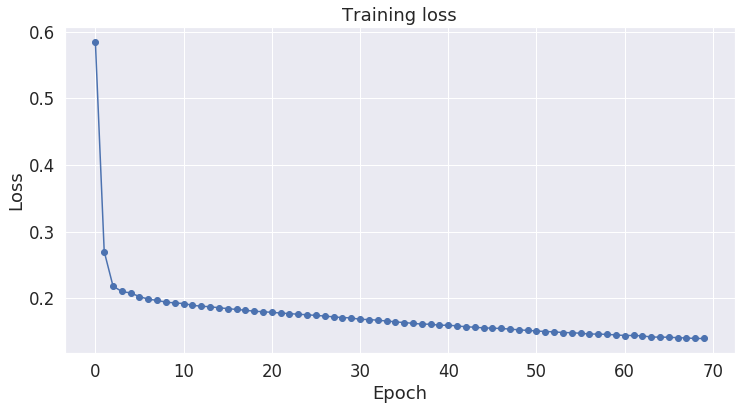

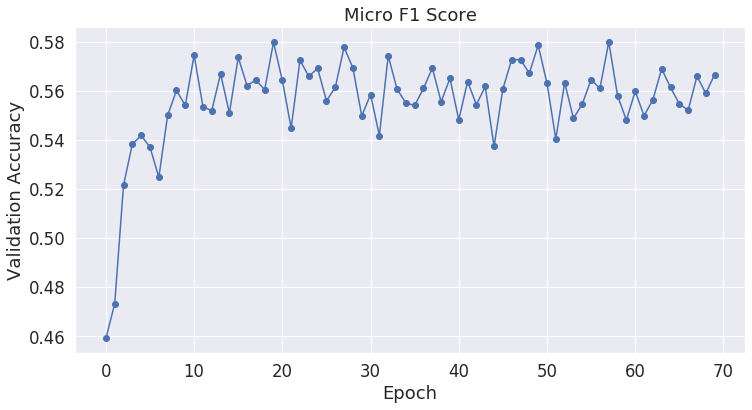

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,micro,macro,weighted,samples
Recall,0.506430,0.362266,0.506430,0.561534
Precision,0.651047,0.659060,0.644889,0.664484
F_Score,0.569704,0.432013,0.545994,0.565388


In [0]:
train_test = Training_Testing_MM( Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                                  Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                                  Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor, Label_names=Label_names, 
                                  hidden_layer_size = 512, epochs = 70, batch_size= 256, learning_rate=0.001, dropout=0.5, scheduler_step_size = 99999, 
                                  scheduler_lr_fraction = 0.85, sigmoid_thresh = 0.5, num_maxout_units = 5, weight_decay = 0.001, max_norm = 10)
train_test.Train()
train_test.Test()

In [0]:
print(train_test.class_wise_metrics)

              precision    recall  f1-score   support

      Action       0.65      0.82      0.73      4209
   Adventure       0.59      0.65      0.62      2591
   Animation       0.41      0.45      0.43      1615
   Biography       0.50      0.53      0.51      1549
      Comedy       0.44      0.55      0.49      1094
       Crime       0.48      0.47      0.48      1032
 Documentary       0.42      0.42      0.42       775
       Drama       0.57      0.57      0.57       839
      Family       0.71      0.57      0.63       650
     Fantasy       0.32      0.23      0.27       616
   Film-Noir       0.60      0.43      0.50       600
     History       0.38      0.22      0.28       559
      Horror       0.63      0.42      0.50       489
       Music       0.32      0.16      0.21       413
     Musical       0.61      0.39      0.48       404
     Mystery       0.35      0.17      0.23       348
     Romance       0.52      0.37      0.43       323
      Sci-Fi       0.70    